## (미완성) Sementic Segmentation 모델 만들기

### 학습 목표
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

### 루브릭 
- U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가? : **KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.**
- U-Net++ 모델이 성공적으로 구현되었는가? : **U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.**
- U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가? : **U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.**


## 목차
### 0. 환경 설정
### 1. 데이터셋
#### 1) 
#### 2) 
### 2. 모델 구현
#### 1) U-Net
#### 2) U-Net++
### 3. 모델 시각화
#### 1) 
#### 2)
---

### 0. 환경 설정

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

folder = 'Colab Notebooks'
project_dir = 'going_deeper_CV'

base_path = Path('/content/gdrive/My Drive')
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
  if x.is_dir():
    dir_name = str(x.relative_to(project_path))
    os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f'현재 디렉토리 위치: {os.getcwd()}')

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/going_deeper_CV


In [ ]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

### 1. 데이터셋 준비


#### 1) 데이터 로더 만들기
1. augmentation을 적용 (`albumentations`라이브러리 사용)
2. **입력값 (224, 224), 출력값 (224, 224)** 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱
3. 학습셋의 일정량을 validation 셋으로 활용할 수 있도록 함

In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

* `HorizontalFlip`
* `RandomSizedCrop`
* `Compose`
* `OneOf`
* `Resize`

In [ ]:
dir_path = os.getcwd()+'/datasets/dataloader/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

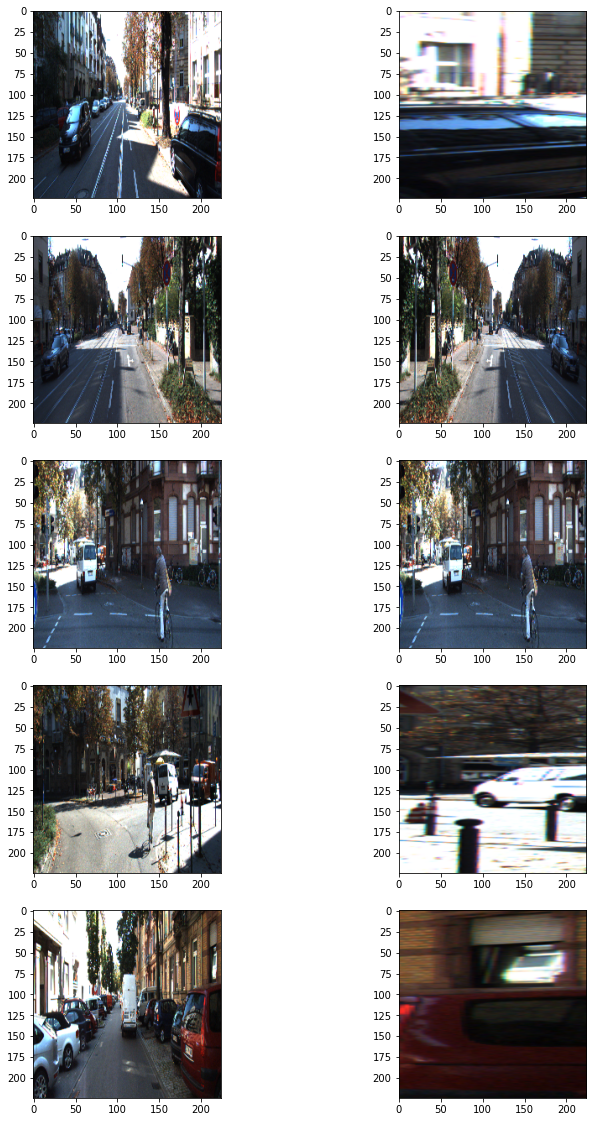

In [ ]:
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()


```
Custom data generator를 만들 때는 tf.keras.utils.Sequence 클래스를 상속하는 것으로 시작한다.
Sequence는 __getitem__, __len__, on_epoch_end, __iter__를 sub method로서 가지고 있다.

```
* `__init__`: 클래스를 생성할 때 실행되는 초기화 생성자
* `__getiten__`: 클래스의 인덱스에 접근할 때 자동으로 호출되는 메서드. index 접근으로 원하는 값을 얻을 수 있게 한다.
* `__len__`: 내장함수`len()`을 구현하기 위해 호출되며, 객체의 길이를 반환한다.
* `on_epoch_end(epoch, logs=None)`: 매번 epoch이 끝날 때 호출된다. `tf.keras.callbacks.Callback`의 메소드이며, `logs['loss']`에 현재 epoch 기준 loss가 저장된다. `model.fit()`인자 등에 따라서 `acc`,`val_loss`등 도 저장된다.
* `__iter__`: iterable 객체를 만들 때 필요. 변수 id의 iterator 객체를 반환한다.

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):

  def __init__(self, dir_path, batch_size=16, img_size=(224, 224, 3), output_size=(224, 224), is_train=True, augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

https://hwiyong.tistory.com/241    
https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac

### 2. 모델 구현

#### 1) U-Net

In [ ]:
model_path = os.getcwd()+'/datasets/dataloader/training/seg_model_unet.h5'
model = tf.keras.models.load_model(model_path)

In [ ]:
def get_output(model, preproc, image_path, output_path):
  origin_img = imread(image_path)
  data = {'image':origin_img}
  processed = preproc(**data)
  output = model(np.expand_dims(processed['image']/255, axis=0))
  output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
  output = Image.fromarray(output)
  background = Image.fromarray(origin_img).convert('RGBA')
  output = output.resize(origin_img.shape[1], origin_img.shape[0]).convert('RGBA')
  output = Image.blend(background, output, alpha = 0.5)
  output.show()
  return output

In [ ]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

ValueError: ignored